### Analysis description
Participants were invited to report the direction of a 1/f noise pattern that changed as a function <br/>
of the parameter Kappa controling the dispersion of the visual orientation contained within the pattern.<br/>
We here compute the perfomance as a function of the exprimental conditions (pRF3T or pRF7T) per trials or across trials .<br/>

In [64]:
# Imports
import os
import numpy as np
import pandas as pd
import ipdb
import bids
import warnings
warnings.filterwarnings('ignore')
from scipy import interpolate

# Figure imports
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.express as px
from plot_utils import plotly_template

def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    A = np.array(A)
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

# Define parameters
subjects = ['sub-01','sub-02','sub-03','sub-05']
scan_tasks = ['pRF3T','pRF7T']

# Define folders
base_dir = '/home/mszinte/disks/meso_S/data/pRF3T7T'
bids_dir = "{}".format(base_dir)
behav_dir = "{}/derivatives/behav_data".format(base_dir)

# Get BIDS files
bids.config.set_option('extension_initial_dot', True)
layout = bids.BIDSLayout(bids_dir, 'synthetic')

- [x] check df of perf / stair value correct
- [x] check if it is correctly saved in the right files
- [ ] fix error with errorbar
- [ ] save graph

### Compute results performance and staircase as a function of trials and gaze/attention conditions
#### Individual level

In [13]:
# Compute per participant
for subject in subjects:    
    # get filenames
    pRF3T_fn = layout.get(subject=subject[4:], suffix='events', return_type='filename', task='pRF3T')
    pRF7T_fn = layout.get(subject=subject[4:], suffix='events', return_type='filename', task='pRF7T')
    
    for scan_task in scan_tasks:
        exec("runs = {}_fn".format(scan_task))
        if len(runs)>0:
            for run_num, run, in enumerate(runs):
                run_df = pd.read_csv(run,sep="\t")
                perf = [np.nanmean(run_df.response_val[0:trial]) for trial in np.arange(run_df.shape[0])]
                stim_stair_val = run_df.stim_stair_val

                if run_num == 0:
                    df = pd.DataFrame({'subject': [subject]*run_df.trial_number.shape[0],
                                       'task': [scan_task]*run_df.trial_number.shape[0]})
                    perf_runs = perf
                    stim_stair_val_runs = stim_stair_val
                else:
                    perf_runs = np.vstack((perf_runs,perf))
                    stim_stair_val_runs = np.vstack((stim_stair_val_runs,stim_stair_val))

                df['trial'] = run_df.trial_number
                df['perf_run{}'.format(run_num+1)] = perf
                df['stim_stair_val_run{}'.format(run_num+1)] = stim_stair_val
                if run_num == len(runs)-1:
                    df['perf_mean'] = np.nanmean(perf_runs,axis=0)
                    df['perf_std'] = np.nanstd(perf_runs,axis=0)
                    df['stim_stair_val_mean'] = np.nanmean(stim_stair_val_runs,axis=0)
                    df['stim_stair_val_std'] = np.nanstd(stim_stair_val_runs,axis=0)

            # save data per scan_tasks
            try: os.makedirs("{}/{}".format(behav_dir,subject))
            except: pass
            df_fn = "{}/{}/{}_task-{}_behav.tsv".format(behav_dir,subject,subject,scan_task)
            print('saving {}'.format(df_fn))
            df.to_csv(df_fn, sep="\t", na_rep='NaN',index=False)
        

saving /home/mszinte/disks/meso_S/data/pRF3T7T/derivatives/behav_data/sub-01/sub-01_task-pRF3T_behav.tsv
saving /home/mszinte/disks/meso_S/data/pRF3T7T/derivatives/behav_data/sub-01/sub-01_task-pRF7T_behav.tsv
saving /home/mszinte/disks/meso_S/data/pRF3T7T/derivatives/behav_data/sub-02/sub-02_task-pRF3T_behav.tsv
saving /home/mszinte/disks/meso_S/data/pRF3T7T/derivatives/behav_data/sub-02/sub-02_task-pRF7T_behav.tsv
saving /home/mszinte/disks/meso_S/data/pRF3T7T/derivatives/behav_data/sub-03/sub-03_task-pRF3T_behav.tsv
saving /home/mszinte/disks/meso_S/data/pRF3T7T/derivatives/behav_data/sub-03/sub-03_task-pRF7T_behav.tsv
saving /home/mszinte/disks/meso_S/data/pRF3T7T/derivatives/behav_data/sub-05/sub-05_task-pRF7T_behav.tsv


#### Plot performance and staircase across trials

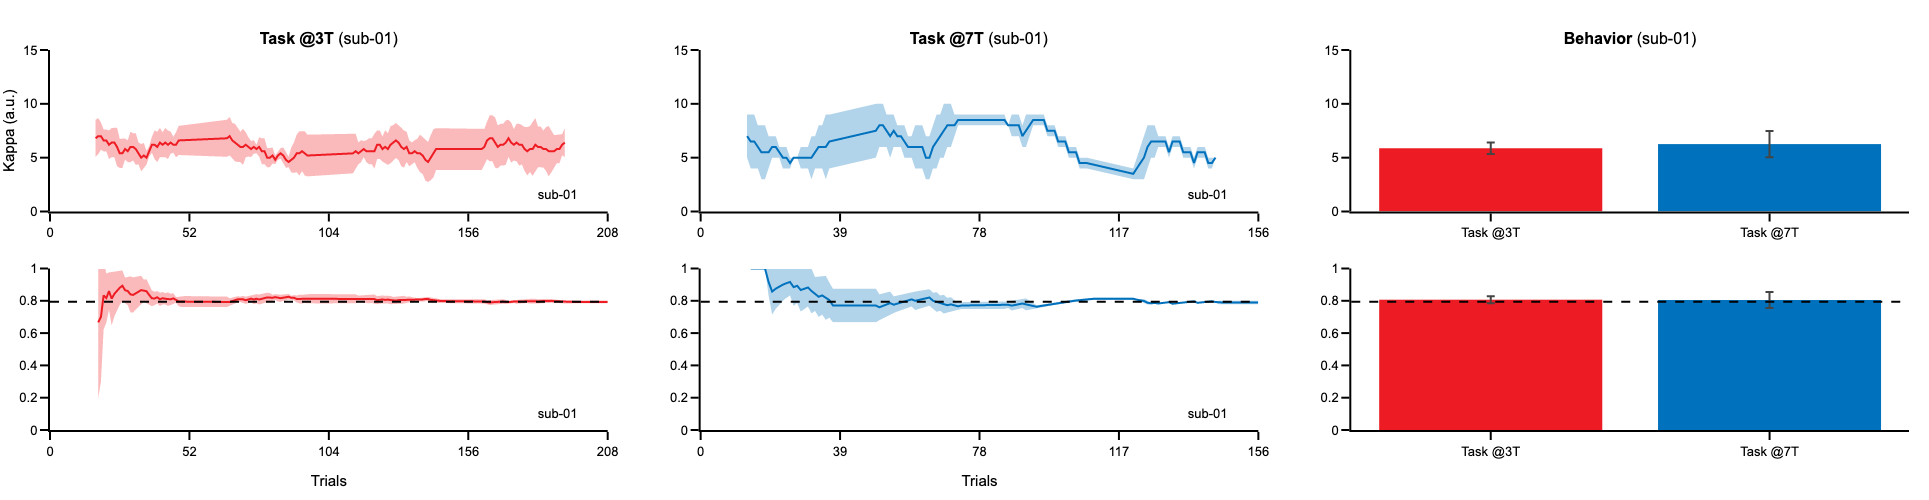

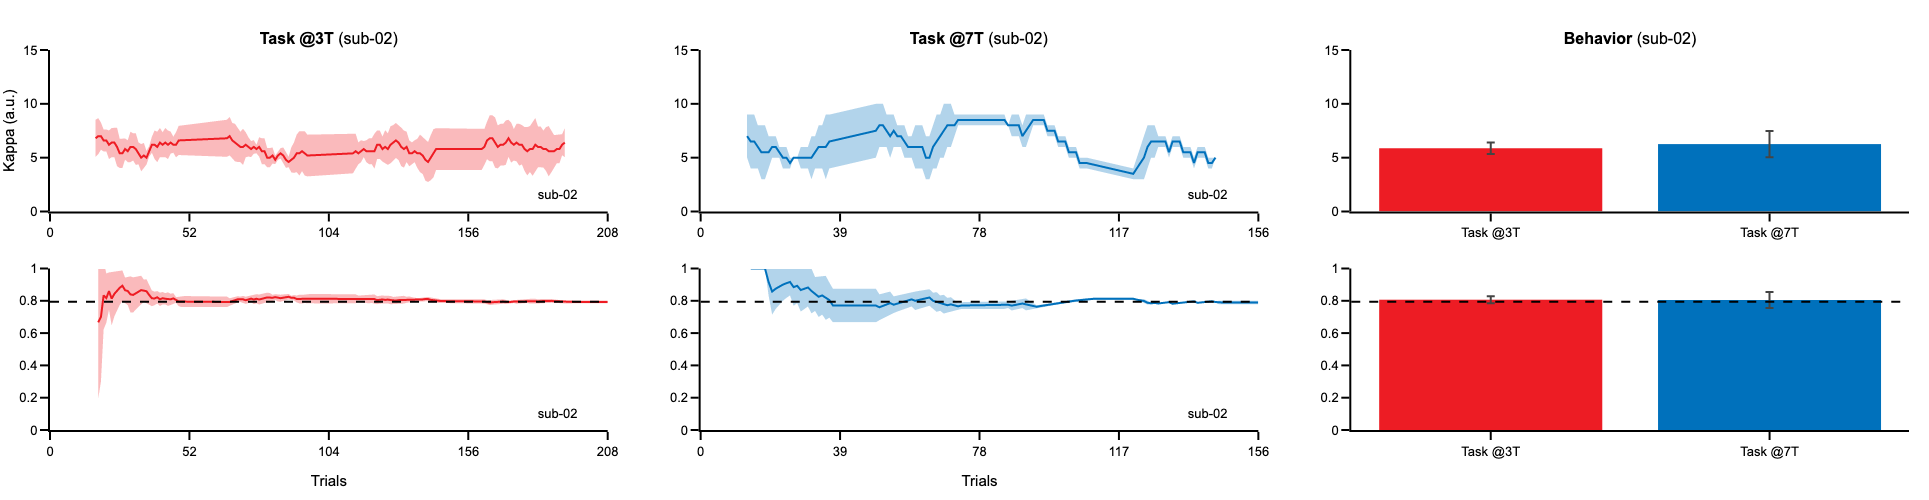

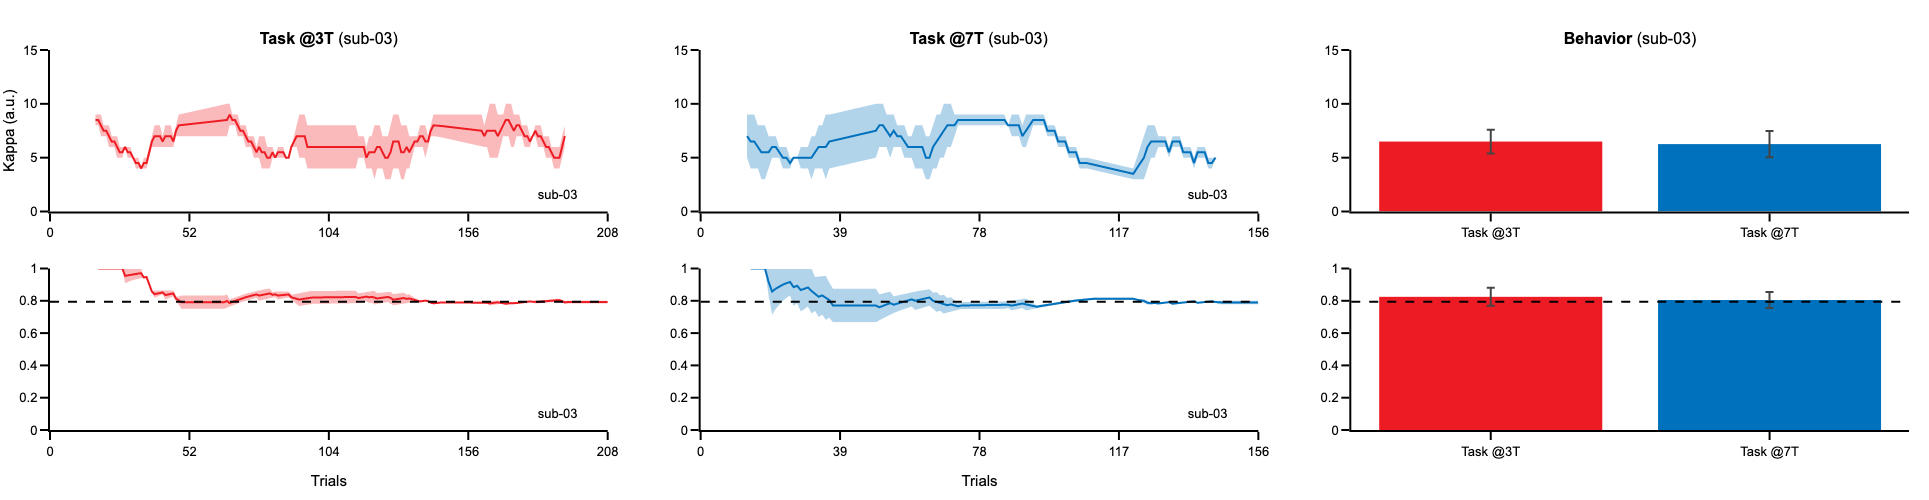

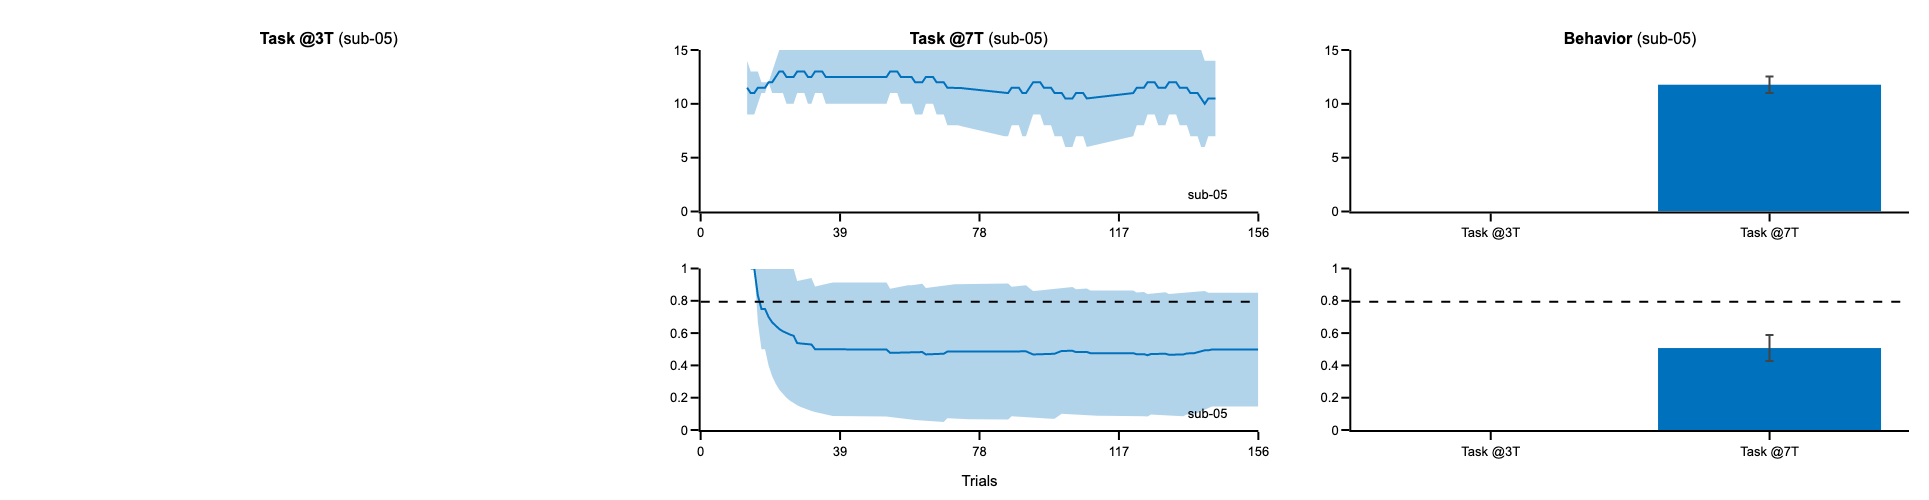

In [67]:
# General figure settings
template_specs = dict(  axes_color="rgba(0, 0, 0, 1)",
                        axes_width=2,
                        axes_font_size=13,
                        bg_col="rgba(255, 255, 255, 1)",
                        font='Arial',
                        title_font_size=15,
                        plot_width=1.5)
fig_template = plotly_template(template_specs)

y_range_stair = [0,15]
y_range_perf = [0,1]
pRF3T_line_col = "rgba(237, 28, 36, 1)"
pRF7T_line_col = "rgba(0, 113, 188, 1)"
pRF3T_area_col = "rgba(237, 28, 36, 0.3)"
pRF7T_area_col = "rgba(0, 113, 188, 0.3)"
tasks_label = ['Task @3T', 'Task @7T']

# Subplot settings
rows, cols = 2, 3
fig_height, fig_width = 500,1250
column_widths,row_heights = [1,1,1],[1,1]
sb_specs = [[{},{},{}],[{},{},{}]]
perf_expected = (1/2**(1/3))

hovertemplate_stair = 'Trial: %{x:2.0f}<br>' + 'Kappa: %{y:2.2f}'
hovertemplate_perf = 'Trial: %{x:2.0f}<br>' + 'Perf: %{y:1.2f}'
hovertemplate_stair_task = 'Task: %{x}<br>' + 'Kappa: %{y:2.2f}'
hovertemplate_perf_task = 'Task: %{x}<br>' + 'Perf: %{y:1.2f}'

for subject in subjects:
        
    subplot_titles = ('<b>Task @3T</b> ({})'.format(subject), 
                      '<b>Task @7T</b> ({})'.format(subject),
                      '<b>Behavior</b> ({})'.format(subject))
    
    
    if subject != 'sub-05':
        prf3t_df = pd.read_csv("{}/{}/{}_task-pRF3T_behav.tsv".format(behav_dir,subject,subject), sep="\t") 
        prf7t_df = pd.read_csv("{}/{}/{}_task-pRF7T_behav.tsv".format(behav_dir,subject,subject), sep="\t")
        
        perf_mean_scantasks_mean = [prf3t_df.perf_mean.mean(), prf7t_df.perf_mean.mean()]
        perf_mean_scantasks_std = [prf3t_df.perf_mean.std(), prf7t_df.perf_mean.std()]
        stim_stair_val_mean_scantasks_mean = [prf3t_df.stim_stair_val_mean.mean(), prf7t_df.stim_stair_val_mean.mean()]
        stim_stair_val_mean_scantasks_std = [prf3t_df.stim_stair_val_mean.std(), prf7t_df.stim_stair_val_mean.std()]
    else:
        prf3t_df = False
        prf7t_df = pd.read_csv("{}/{}/{}_task-pRF7T_behav.tsv".format(behav_dir,subject,subject), sep="\t")
        
        perf_mean_scantasks_mean = [np.nan, prf7t_df.perf_mean.mean()]
        perf_mean_scantasks_std = [np.nan, prf7t_df.perf_mean.std()]
        stim_stair_val_mean_scantasks_mean = [np.nan, prf7t_df.stim_stair_val_mean.mean()]
        stim_stair_val_mean_scantasks_std = [np.nan, prf7t_df.stim_stair_val_mean.std()]
    
    fig = make_subplots(rows=rows, cols=cols, specs=sb_specs, print_grid=False, vertical_spacing=0.15, horizontal_spacing=0.05, 
                    column_widths=column_widths, row_heights=row_heights,  subplot_titles=subplot_titles)
    
    for task_num, scan_task in enumerate(scan_tasks):
            
        if scan_task == 'pRF3T': 
            if subject == 'sub-05': plot_graph = False
            else: plot_graph = True
            task_df = prf3t_df
            line_col = pRF3T_line_col
            area_col = pRF3T_area_col
        elif scan_task == 'pRF7T':
            plot_graph = True
            task_df = prf7t_df
            line_col = pRF7T_line_col
            area_col = pRF7T_area_col

        # subject annotation
        if plot_graph:

            fig.add_annotation(x=task_df.trial.max()*0.95, y=y_range_stair[1]*0.1, text=subject, showarrow=False, 
                                font_size = template_specs['axes_font_size'], xanchor = 'right', yanchor='middle', row=1, col=task_num+1)
            fig.add_annotation(x=task_df.trial.max()*0.95, y=y_range_perf[1]*0.1, text=subject, showarrow=False, 
                                font_size = template_specs['axes_font_size'], xanchor = 'right', yanchor='middle', row=2, col=task_num+1)

            # staircase attend-bar
            fig.append_trace(go.Scatter(x=task_df.trial, y=fill_nan(task_df.stim_stair_val_mean), line_color=line_col, showlegend=False, hovertemplate=hovertemplate_stair),row=1, col=task_num+1)
            fig.append_trace(go.Scatter(x=task_df.trial, y=fill_nan(task_df.stim_stair_val_mean+task_df.stim_stair_val_std), 
                                        mode='lines',line_width=0, fillcolor=area_col, showlegend=False, hoverinfo='skip'), row=1, col=task_num+1)
            fig.append_trace(go.Scatter(x=task_df.trial, y=fill_nan(task_df.stim_stair_val_mean-task_df.stim_stair_val_std), 
                                        mode='lines',line_width=0, fillcolor=area_col, fill='tonexty', showlegend=False, hoverinfo='skip'),row=1, col=task_num+1)

            # perf attend-bar
            fig.append_trace(go.Scatter(x=task_df.trial, y=task_df.perf_mean, line_color=line_col, showlegend=False, hovertemplate=hovertemplate_perf),row=2, col=task_num+1)
            fig.append_trace(go.Scatter(x=task_df.trial, y=task_df.perf_mean+task_df.perf_std, 
                                        mode='lines',line_width=0, fillcolor=area_col, showlegend=False, hoverinfo='skip'), row=2, col=task_num+1)
            fig.append_trace(go.Scatter(x=task_df.trial, y=task_df.perf_mean-task_df.perf_std, 
                                        mode='lines',line_width=0, fillcolor=area_col, fill='tonexty', showlegend=False, hoverinfo='skip'),row=2, col=task_num+1)

            fig.add_hline(y=perf_expected, line_color='black',  row=2, col=task_num+1, line_dash='dash')

    # across tasks
    fig.append_trace(go.Bar(x=tasks_label, y=stim_stair_val_mean_scantasks_mean, showlegend=False, marker_color=[pRF3T_line_col,pRF7T_line_col], hovertemplate=hovertemplate_stair_task,
                            error_y_type='data', error_y_symmetric=False, error_y_array=stim_stair_val_mean_scantasks_std, error_y_arrayminus=stim_stair_val_mean_scantasks_std),row=1, col=3)

    fig.append_trace(go.Bar(x=tasks_label, y=perf_mean_scantasks_mean, showlegend=False, marker_color=[pRF3T_line_col,pRF7T_line_col], hovertemplate=hovertemplate_stair_task,
                            error_y_type='data', error_y_symmetric=False, error_y_array=perf_mean_scantasks_std, error_y_arrayminus=perf_mean_scantasks_std),row=2, col=3)

    fig.add_hline(y=perf_expected, line_color='black',  row=2, col=3, line_dash='dash')
    
    # set axis
    for row in np.arange(rows):
        for col in np.arange(cols):
            fig.update_xaxes(visible=True, ticklen=8, linewidth=template_specs['axes_width'], row=row+1, col=col+1)
            fig.update_yaxes(visible=True, ticklen=8, linewidth=template_specs['axes_width'], row=row+1, col=col+1)

    # set figure
    fig.layout.update(xaxis_range =[0,208], xaxis4_range=[0,208], xaxis_title='', xaxis4_title='Trials', xaxis_dtick=52, xaxis4_dtick=52,
                      xaxis2_range=[0,156], xaxis5_range=[0,156], xaxis2_title='', xaxis5_title='Trials', xaxis2_dtick=39, xaxis5_dtick=39,
                      
                      yaxis_range=y_range_stair, yaxis4_range=y_range_perf, yaxis_title='Kappa (a.u.)',
                      yaxis2_range=y_range_stair, yaxis5_range=y_range_perf, yaxis2_title='',
                      yaxis3_range=y_range_stair, yaxis6_range=y_range_perf,
 
                      template=fig_template, width=fig_width, height=fig_height, margin_l=50, margin_r=20, margin_t=50, margin_b=70,
                      legend_yanchor='top', legend_y=0.995, legend_xanchor='left', legend_x=0.01, legend_bgcolor='rgba(255,255,255,0)', legend_tracegroupgap=1)
    # show and save figure
    fig.show(config={"displayModeBar": False})
    fig.write_image("{}/{}/{}_behav.pdf".format(behav_dir, subject, subject))
    fig.write_html("{}/{}/{}_behav.html".format(behav_dir, subject, subject),config={"displayModeBar": False})